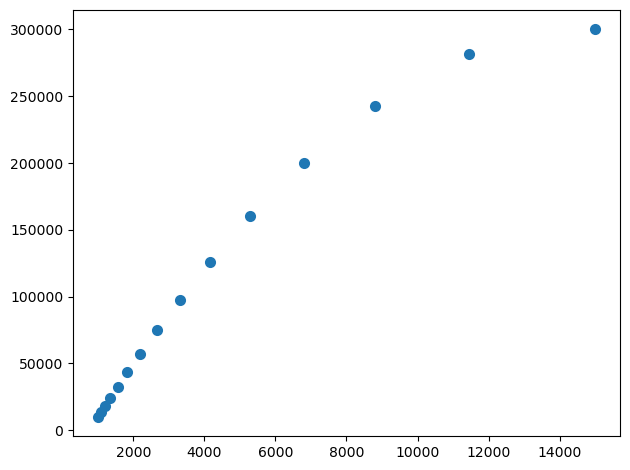

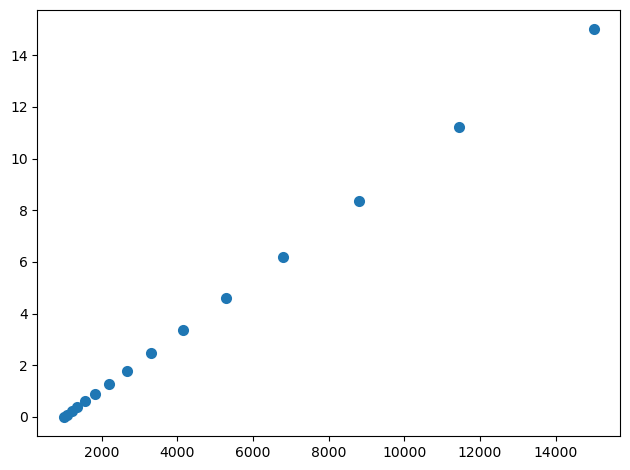

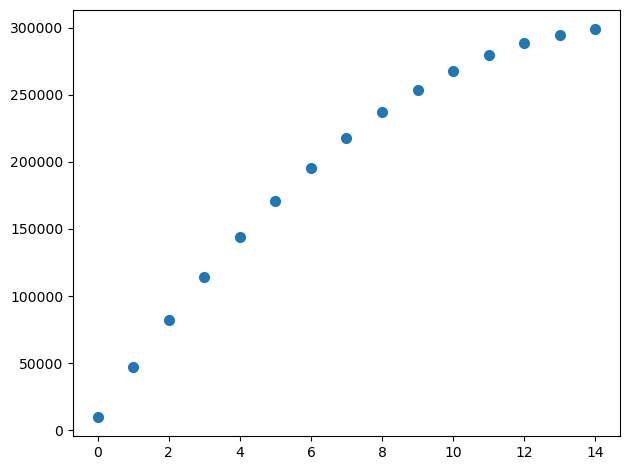

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# --- minimal stand‑in for your project’s Args object ----------
@dataclass
class Args:
    densify_start: int = 1_000        # first iteration you densify at
    densify_end:   int = 15_000       # last iteration you densify at
    densify_interval: int = 1_000     # *uniform* interval that the current code uses
    budget: int = 300_000             # cloning budget
    clone_schedule: str = "quadratic"    # or "quadratic"

args = Args()

# ----------------------------------------------------------------
# existing helper -------------------------------------------------
num_densify_iter = args.densify_end - args.densify_start
N = num_densify_iter // args.densify_interval + 1      # number of densification events
S = 10_000                                             # baseline number of tets

def target_num(x: int):
    """Return #tets you want after the x‑th densification."""
    if args.clone_schedule == "linear":
        k = (args.budget - S) // N
        return k * x + S
    elif args.clone_schedule == "quadratic":
        k = 2 * (args.budget - S) / N
        a = (args.budget - S - k * N) / N**2
        return int(a * x**2 + k * x + S)
    else:
        raise ValueError(f"Clone schedule '{args.clone_schedule}' not supported")

# ----------------------------------------------------------------
# new helper: front‑loaded (high‑frequency‑then‑slow‑down) schedule
def densify_schedule(start: int,
                     end: int,
                     n_events: int,
                     mode: str = "sqrt"):
    """
    Generate `n_events` iteration indices between `start` and `end`
    with decreasing frequency.  Modes:
        • 'sqrt'    – spacing ∝ √t   (simple, monotone)
        • 'exp'     – exponential easing
        • 'logistic'– S‑curve
    """
    t = np.linspace(0.0, 1.0, n_events)
    if mode == "sqrt":
        w = t**2                         # lots of points early, sparse later
    elif mode == "exp":
        g = 4.0
        w = (np.exp(g*t) - 1) / (np.exp(g) - 1)
    elif mode == "logistic":
        k = 10.0
        w = 1 / (1 + np.exp(-k*(t-0.5)))
        w = (w - w.min()) / (w.max() - w.min())
    else:
        raise ValueError("mode must be 'sqrt', 'exp', or 'logistic'")
    iters = np.round(start + w * (end - start)).astype(int)
    iters[0] = start                     # make sure start & end are included
    iters[-1] = end
    return np.unique(iters)

dschedule = densify_schedule(args.densify_start,
                            args.densify_end,
                            N,
                            mode="exp")
targets = [target_num((i - args.densify_start) / num_densify_iter * N) for i in dschedule]

# ----------------------------------------------------------------
# simple plot -----------------------------------------------------
plt.figure()
plt.scatter(dschedule, targets, linewidth=2)
plt.tight_layout()
plt.show()
plt.scatter(dschedule, [(i - args.densify_start) / num_densify_iter * N for i in dschedule], linewidth=2)
plt.tight_layout()
plt.show()
rng = list(range(N))
plt.scatter(rng, [target_num(i) for i in rng], linewidth=2)
plt.tight_layout()
plt.show()